In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [26]:
# Load the dataset
data = pd.read_csv('/Users/geraldzhao/Desktop/ML_final_proj/train.csv')  

In [27]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [28]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [29]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')
cat_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [30]:
# Create preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', cat_imputer),
    ('onehot', cat_encoder)
])

num_pipeline = Pipeline([
    ('imputer', num_imputer),
    ('scaler', scaler)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols),
        ('num', num_pipeline, numerical_cols)
    ])

In [31]:
# Splitting the data into features and target variable
X = data.drop('Transported', axis=1)
y = data['Transported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Create a complete pipeline including the preprocessing and the classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC())])

In [33]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Cabin', 'Destination',
                                                   'VIP']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck'])])),
                ('classifier', SVC())])

In [34]:
# Make predictions
predictions = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7866589994249569


In [35]:
def train_and_create_submission(kernel_type, C=1.0, degree=None, gamma=None):
    # Set up the classifier options
    classifier_options = {
        'kernel': kernel_type,
        'C': C  # Regularization parameter
    }
    if degree is not None and kernel_type == 'poly':
        classifier_options['degree'] = degree
    if gamma is not None:
        classifier_options['gamma'] = gamma

    # Create a pipeline with the specified kernel and options
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(**classifier_options))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate on the training test set
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Kernel: {kernel_type}, C: {C}, Degree: {degree if degree is not None else "Default"}, Gamma: {gamma if gamma is not None else "Default"}')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, predictions))
    
    # Predict on the actual test set
    test_predictions = pipeline.predict(test_data)
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Transported': test_predictions.astype(bool)
    })
    
    # Save the submission file
    submission_filename = f'submission_{kernel_type}_C{C}_degree{degree}_gamma{gamma}.csv'
    submission.to_csv(submission_filename, index=False)
    print(f'Submission file created for {kernel_type} kernel with C {C}, degree {degree}, and gamma {gamma}: {submission_filename}')



In [36]:
#rbf kernel
train_and_create_submission('rbf', C=0.1, gamma=0.01)
train_and_create_submission('rbf', C=1, gamma=0.1)
train_and_create_submission('rbf', C=10, gamma=1)

Kernel: rbf, C: 0.1, Degree: Default, Gamma: 0.01
Accuracy: 0.753306497987349
              precision    recall  f1-score   support

       False       0.71      0.85      0.77       861
        True       0.81      0.66      0.73       878

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739

Submission file created for rbf kernel with C 0.1, degree None, and gamma 0.01: submission_rbf_C0.1_degreeNone_gamma0.01.csv
Kernel: rbf, C: 1, Degree: Default, Gamma: 0.1
Accuracy: 0.7849338700402531
              precision    recall  f1-score   support

       False       0.80      0.76      0.78       861
        True       0.77      0.81      0.79       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739

Submission file created for rbf kernel with C 1, degree None, and g

In [37]:
#poly kernel
train_and_create_submission('poly', C=0.1, degree=2, gamma='scale')
train_and_create_submission('poly', C=1, degree=3, gamma='auto')
train_and_create_submission('poly', C=10, degree=4, gamma=0.5)


Kernel: poly, C: 0.1, Degree: 2, Gamma: scale
Accuracy: 0.7682576193214491
              precision    recall  f1-score   support

       False       0.74      0.82      0.78       861
        True       0.80      0.72      0.76       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739

Submission file created for poly kernel with C 0.1, degree 2, and gamma scale: submission_poly_C0.1_degree2_gammascale.csv
Kernel: poly, C: 1, Degree: 3, Gamma: auto
Accuracy: 0.5048878665899943
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       861
        True       0.50      1.00      0.67       878

    accuracy                           0.50      1739
   macro avg       0.25      0.50      0.34      1739
weighted avg       0.25      0.50      0.34      1739



/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Submission file created for poly kernel with C 1, degree 3, and gamma auto: submission_poly_C1_degree3_gammaauto.csv
Kernel: poly, C: 10, Degree: 4, Gamma: 0.5
Accuracy: 0.7314548591144335
              precision    recall  f1-score   support

       False       0.73      0.72      0.73       861
        True       0.73      0.75      0.74       878

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739

Submission file created for poly kernel with C 10, degree 4, and gamma 0.5: submission_poly_C10_degree4_gamma0.5.csv


In [38]:
#sigmoid kernel
train_and_create_submission('sigmoid', C=0.1, gamma=0.01)
train_and_create_submission('sigmoid', C=1, gamma=0.1)
train_and_create_submission('sigmoid', C=10, gamma=1)


Kernel: sigmoid, C: 0.1, Degree: Default, Gamma: 0.01
Accuracy: 0.7498562392179413
              precision    recall  f1-score   support

       False       0.71      0.84      0.77       861
        True       0.81      0.66      0.73       878

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739

Submission file created for sigmoid kernel with C 0.1, degree None, and gamma 0.01: submission_sigmoid_C0.1_degreeNone_gamma0.01.csv
Kernel: sigmoid, C: 1, Degree: Default, Gamma: 0.1
Accuracy: 0.6808510638297872
              precision    recall  f1-score   support

       False       0.68      0.67      0.68       861
        True       0.68      0.69      0.69       878

    accuracy                           0.68      1739
   macro avg       0.68      0.68      0.68      1739
weighted avg       0.68      0.68      0.68      1739

Submission file created for sigmoid kernel with C 

Below is an approach to output the different training results in one table for:
different kernels: ['rbf', 'poly', 'sigmoid']
different C_values: [0.1, 1, 10]
different gamma_values: ['scale', 'auto']
different degrees: [2, 3]  # Only used for poly

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


data = pd.read_csv('/Users/geraldzhao/Desktop/ML_final_proj/train.csv')

categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')
cat_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
# Create preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', cat_imputer),
    ('onehot', cat_encoder)
])

num_pipeline = Pipeline([
    ('imputer', num_imputer),
    ('scaler', scaler)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols),
        ('num', num_pipeline, numerical_cols)
    ])
# Splitting the data into features and target variable
X = data.drop('Transported', axis=1)
y = data['Transported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [44]:
kernels = ['rbf', 'poly', 'sigmoid']
C_values = [0.1, 1, 10]
gamma_values = ['scale', 'auto']
degrees = [2, 3, 4, 5]  # Only used for poly

# Function to evaluate models
def evaluate_models():
    results = []
    for kernel in kernels:
        for C in C_values:
            for gamma in gamma_values:
                if kernel == 'poly':
                    for degree in degrees:
                        classifier = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
                        pipeline = Pipeline([
                            ('preprocessor', preprocessor),
                            ('classifier', classifier)
                        ])
                        pipeline.fit(X_train, y_train)
                        # Evaluation
                        train_preds = pipeline.predict(X_train)
                        val_preds = pipeline.predict(X_test)
                        results.append({
                            'Kernel': kernel,
                            'C': C,
                            'Gamma': gamma,
                            'Degree': degree,
                            'Training Accuracy': accuracy_score(y_train, train_preds),
                            'Validation Accuracy': accuracy_score(y_test, val_preds),
                            'Precision': precision_score(y_test, val_preds, average='macro'),
                            'Recall': recall_score(y_test, val_preds, average='macro')
                        })
                else:
                    classifier = SVC(kernel=kernel, C=C, gamma=gamma)
                    pipeline = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', classifier)
                    ])
                    pipeline.fit(X_train, y_train)
                    # Evaluation
                    train_preds = pipeline.predict(X_train)
                    val_preds = pipeline.predict(X_test)
                    results.append({
                        'Kernel': kernel,
                        'C': C,
                        'Gamma': gamma,
                        'Degree': 'N/A',
                        'Training Accuracy': accuracy_score(y_train, train_preds),
                        'Validation Accuracy': accuracy_score(y_test, val_preds),
                        'Precision': precision_score(y_test, val_preds, average='macro'),
                        'Recall': recall_score(y_test, val_preds, average='macro')
                    })

    # Creating DataFrame from results
    df_results_to_return = pd.DataFrame(results)
    return df_results_to_return

# Run the evaluation
df_results = evaluate_models()
print(df_results)

/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/geraldzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

     Kernel     C  Gamma Degree  Training Accuracy  Validation Accuracy  \
0       rbf   0.1  scale    N/A           0.788755             0.772283   
1       rbf   0.1   auto    N/A           0.504602             0.506038   
2       rbf   1.0  scale    N/A           0.827006             0.786659   
3       rbf   1.0   auto    N/A           0.774374             0.760782   
4       rbf  10.0  scale    N/A           0.985620             0.779183   
5       rbf  10.0   auto    N/A           0.757406             0.753306   
6      poly   0.1  scale      2           0.779695             0.768258   
7      poly   0.1  scale      3           0.781996             0.769408   
8      poly   0.1  scale      4           0.782427             0.760782   
9      poly   0.1  scale      5           0.732240             0.721104   
10     poly   0.1   auto      2           0.503307             0.504888   
11     poly   0.1   auto      3           0.503307             0.504888   
12     poly   0.1   auto 

In [42]:
df_results

,Kernel,C,Gamma,Degree,Training Accuracy,Validation Accuracy,Precision,Recall
0,rbf,0.1,scale,N/A,0.788755,0.772283,0.772614,0.772441
1,rbf,0.1,auto,N/A,0.504602,0.506038,0.752735,0.501161
2,rbf,1.0,scale,N/A,0.827006,0.786659,0.787378,0.786397
3,rbf,1.0,auto,N/A,0.774374,0.760782,0.762252,0.761130
4,rbf,10.0,scale,N/A,0.985620,0.779183,0.780928,0.778780
5,rbf,10.0,auto,N/A,0.757406,0.753306,0.761121,0.754132
6,poly,0.1,scale,2,0.779695,0.768258,0.770784,0.768713
7,poly,0.1,scale,3,0.781996,0.769408,0.771589,0.769830
8,poly,0.1,auto,2,0.503307,0.504888,0.252444,0.500000
9,poly,0.1,auto,3,0.503307,0.504888,0.252444,0.500000


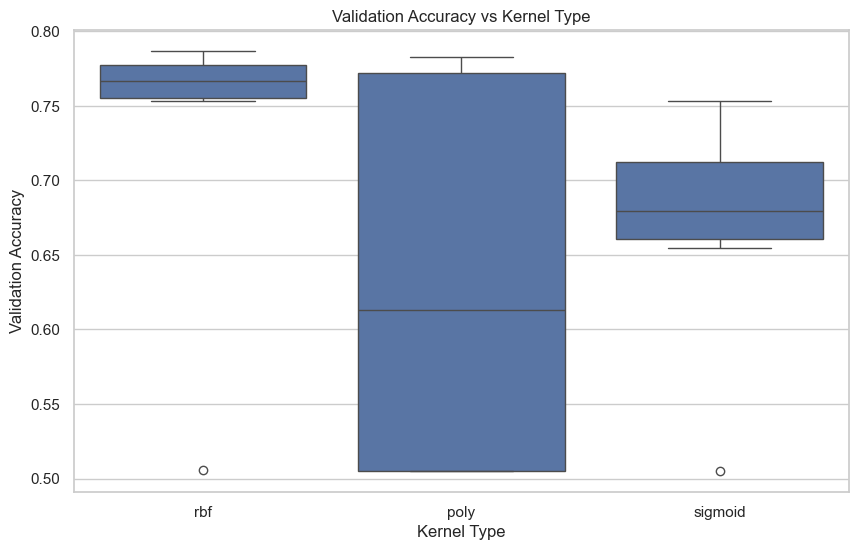

<Figure size 1000x600 with 0 Axes>

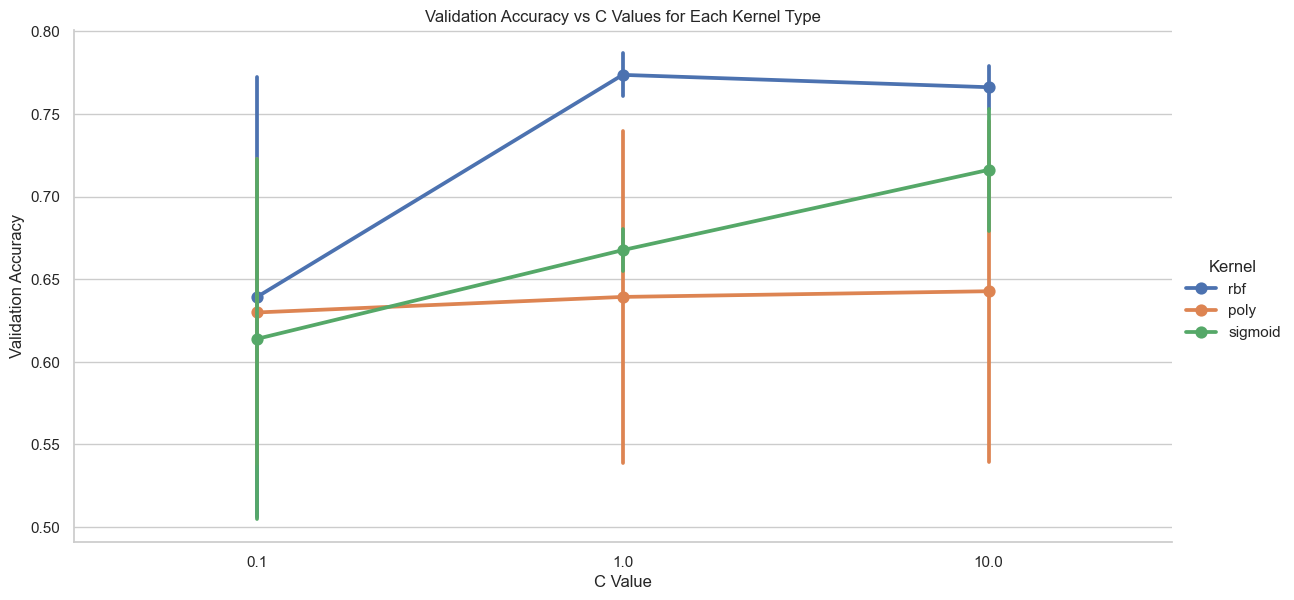

<Figure size 1000x600 with 0 Axes>

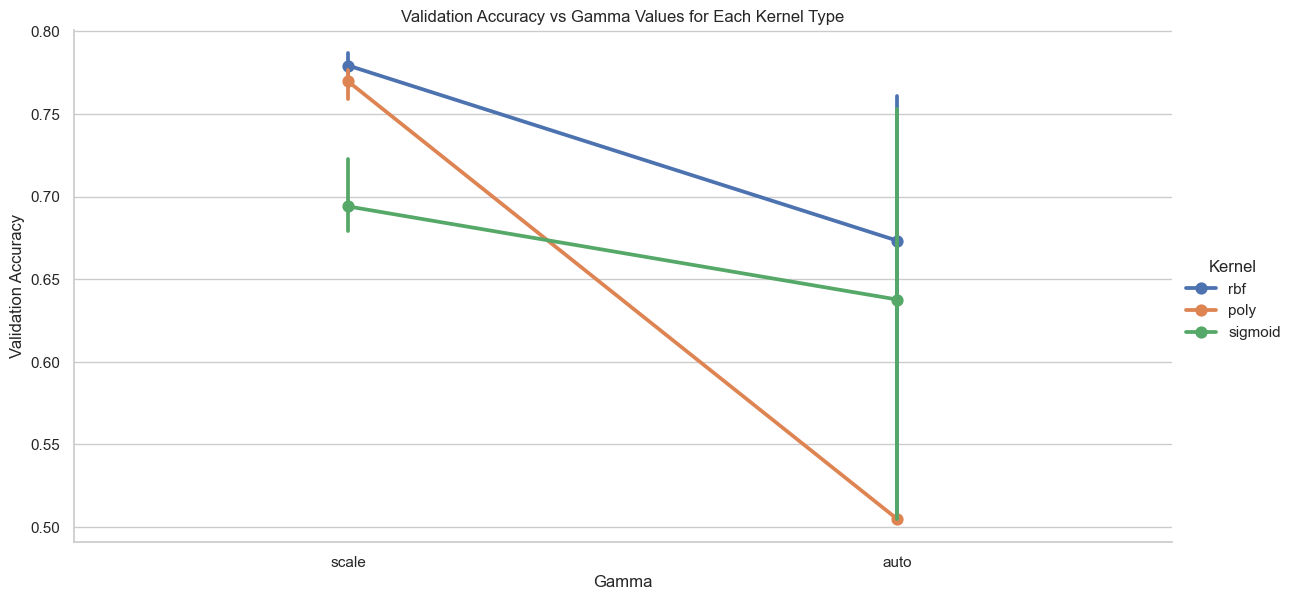

<Figure size 1000x600 with 0 Axes>

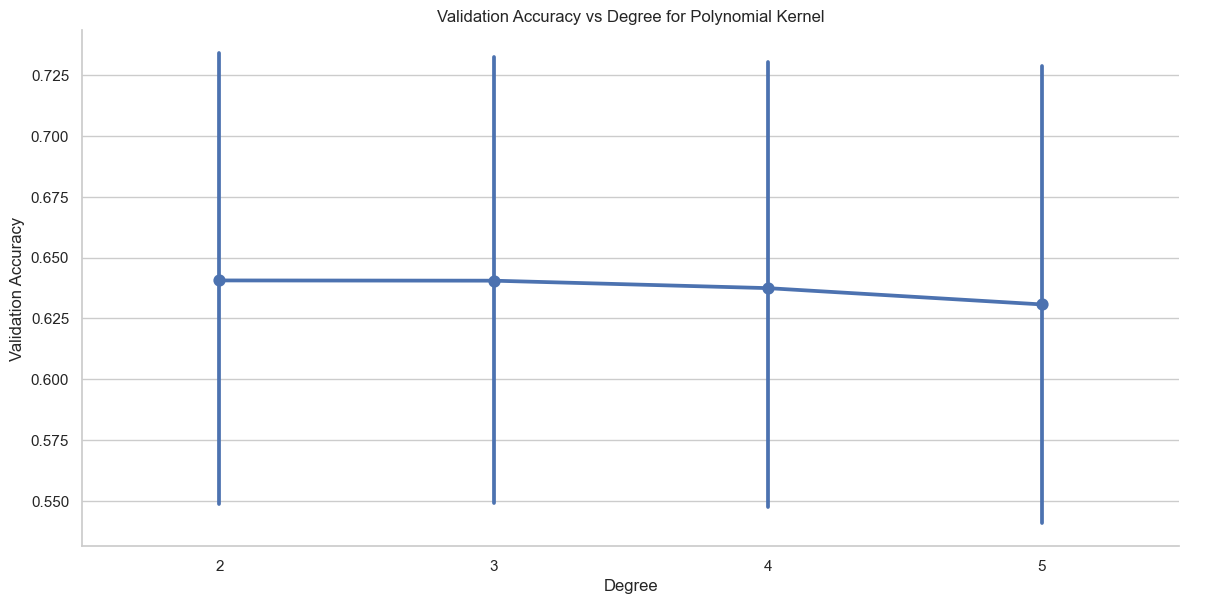

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plot 1: Accuracy vs. Kernel Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results, x='Kernel', y='Validation Accuracy')
plt.title('Validation Accuracy vs Kernel Type')
plt.xlabel('Kernel Type')
plt.ylabel('Validation Accuracy')
plt.show()

# Plot 2: Accuracy vs. C Values for each Kernel
plt.figure(figsize=(10, 6))
sns.catplot(data=df_results, x='C', y='Validation Accuracy', hue='Kernel', kind='point', height=6, aspect=2)
plt.title('Validation Accuracy vs C Values for Each Kernel Type')
plt.xlabel('C Value')
plt.ylabel('Validation Accuracy')
plt.show()

# Plot 3: Accuracy vs. Gamma Values for each Kernel
plt.figure(figsize=(10, 6))
sns.catplot(data=df_results, x='Gamma', y='Validation Accuracy', hue='Kernel', kind='point', height=6, aspect=2)
plt.title('Validation Accuracy vs Gamma Values for Each Kernel Type')
plt.xlabel('Gamma')
plt.ylabel('Validation Accuracy')
plt.show()

# Plot 4: Accuracy vs. Degree (Polynomial only)
poly_results = df_results[df_results['Kernel'] == 'poly']
if not poly_results.empty:
    plt.figure(figsize=(10, 6))
    sns.catplot(data=poly_results, x='Degree', y='Validation Accuracy', kind='point', height=6, aspect=2)
    plt.title('Validation Accuracy vs Degree for Polynomial Kernel')
    plt.xlabel('Degree')
    plt.ylabel('Validation Accuracy')
    plt.show()
